# EDA notebook

Expects the table `raw_power` to be created

In [1]:
import datetime
import sqlite3

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
DB_PATH = 'data/housepower.sqlite'

def execute_sql_query(query, columns=None):
    conn = sqlite3.connect(DB_PATH)
    ret = conn.execute(query).fetchall()
    conn.close()
    return pd.DataFrame(ret) if columns is None else pd.DataFrame(ret, columns=columns)

### Number of rows, timestamp interval

In [3]:
execute_sql_query("""
SELECT
    COUNT(*),
    DATETIME(MIN(STRFTIME('%s', ts)), 'unixepoch'),
    DATETIME(MAX(STRFTIME('%s', ts)), 'unixepoch')
FROM raw_power;
""", ['Row count', 'Min time', 'Max time'])

,Row count,Min time,Max time
0,2075259,2006-12-16 17:24:00,2010-11-26 21:02:00


### Missing values - number of NULLs per row

Any row is either empty entirely, including target variable, or entirely full with all values non-NULL:

In [4]:
execute_sql_query(
"""
SELECT 
    SUM(CASE WHEN n_present = 0 THEN 1 ELSE 0 END) AS fully_empty,
    SUM(CASE WHEN n_present BETWEEN 1 AND 6 THEN 1 ELSE 0 END) AS partially_empty,
    SUM(CASE WHEN n_present = 7 THEN 1 ELSE 0 END) AS fully_filled
FROM (
    SELECT
        (global_active_power IS NOT NULL) +
        (global_reactive_power IS NOT NULL) +
        (voltage IS NOT NULL) +
        (global_intensity IS NOT NULL) +
        (sub_1 IS NOT NULL) +
        (sub_2 IS NOT NULL) +
        (sub_3 IS NOT NULL) AS n_present
    FROM raw_power
) AS t;
""", ['Number of entirely empty rows', 'Number of partially empty rows', 'Number of full rows'])

,Number of entirely empty rows,Number of partially empty rows,Number of full rows
0,25979,0,2049280


### Missing values - number of empty rows per month

In [5]:
df_monthly_empty = execute_sql_query("""
SELECT
    DATE(STRFTIME('%Y-%m-01 00:00:00', ts)) as month,
    1.0 * SUM(global_active_power IS NULL) / COUNT(*) empty_rate
FROM raw_power
GROUP BY month
ORDER BY month;
""", ['ts', 'empty_rate'])
df_monthly_empty['ts'] = pd.to_datetime(df_monthly_empty['ts']).dt.date

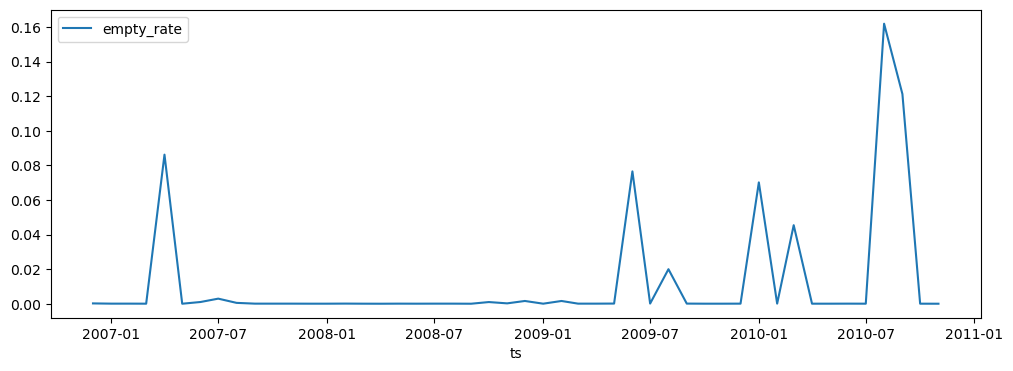

In [6]:
df_monthly_empty.plot(x='ts', y='empty_rate', figsize=(12, 4))
plt.show()

### Missing values - number of empty rows per day (heatmap)

In [13]:
df_daily_empty = execute_sql_query("""
SELECT
    DATE(STRFTIME('%Y-%m-%d 00:00:00', ts)) as day,
    1.0 * SUM(global_active_power IS NULL) / COUNT(*) empty_rate
FROM raw_power
GROUP BY day
ORDER BY day;
""", ['ts', 'empty_rate'])

df_daily_empty['ts'] = pd.to_datetime(df_daily_empty['ts'])
df_daily_empty['month'] = df_daily_empty.ts.dt.to_period('M')
df_daily_empty['day'] = df_daily_empty.ts.dt.day
df_daily_empty.drop('ts', axis=1, inplace=True)

df_daily_empty_wide = df_daily_empty.set_index(['month', 'day'])['empty_rate'].unstack(level=0)

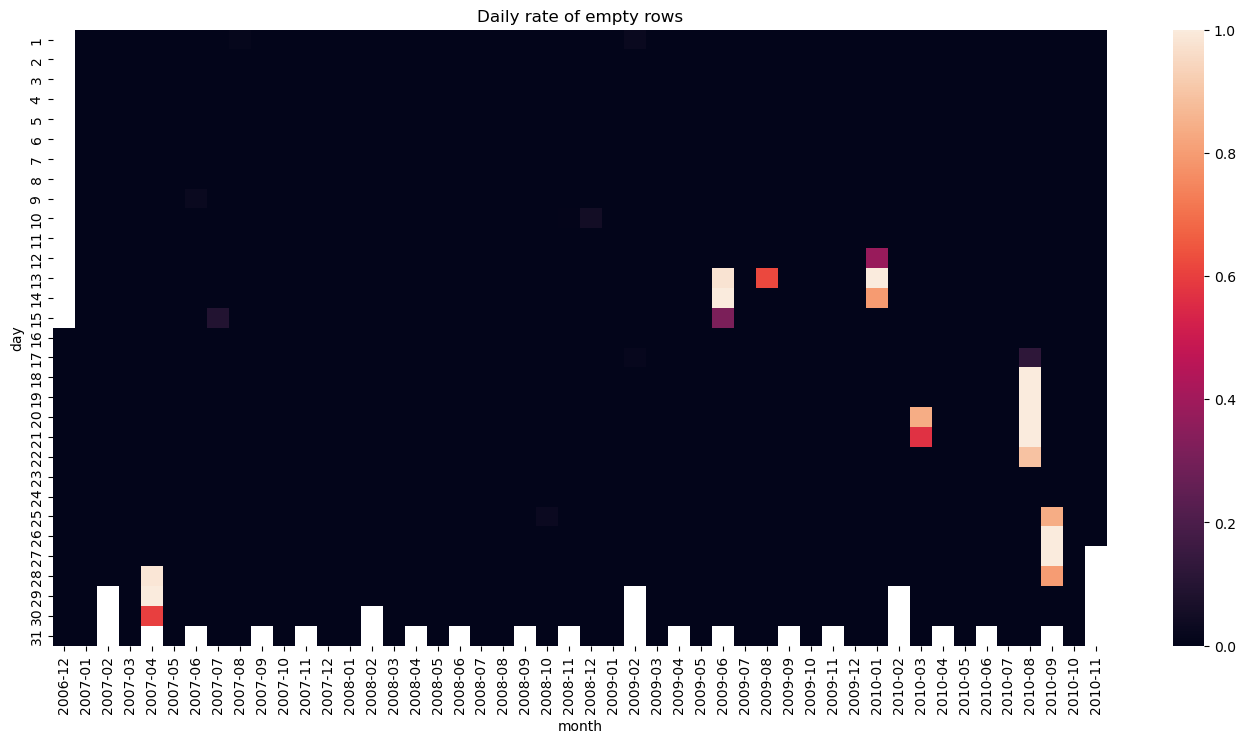

In [20]:
fig, ax = plt.subplots(figsize=(17, 8))
sns.heatmap(df_daily_empty_wide, ax=ax)
plt.title('Daily rate of empty rows')
plt.show()